Word Embeddings
===============

Loading the Data
--------------------

Before we begin working with word embeddings in full, let's load a corpus manifest file, which will help us keep track of all the obituaries.

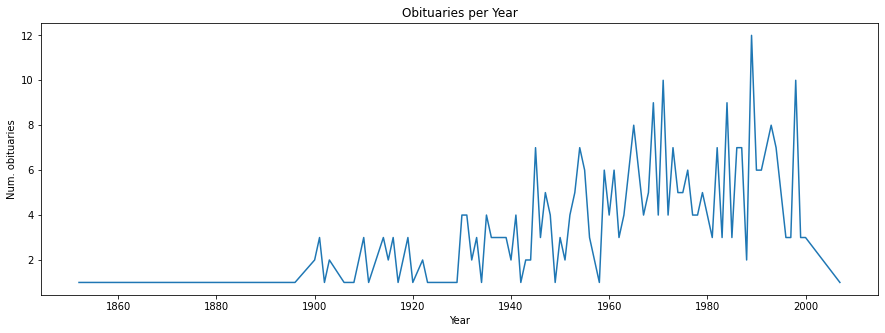

In [1]:
import pandas as pd

manifest = pd.read_csv('data/session_three/manifest.csv', index_col=0)
manifest = manifest.assign(YEAR = pd.to_datetime(manifest['YEAR'], format='%Y').dt.year)

manifest.groupby('YEAR').count().plot(
    figsize=(15, 5),
    y='NAME',
    title='Obituaries per Year',
    ylabel='Num. obituaries',
    xlabel='Year',
    legend=False
);

Here's a sampling of the corpus:

In [2]:
for idx in manifest.sample(5).index:
    name, date = manifest.loc[idx, 'NAME'], manifest.loc[idx, 'YEAR']
    print(f"{name} ({date})")

Samuel Beckett (1989)
Henry R Luce (1967)
Jean Piaget (1980)
Adlai Ewing Stevenson (1965)
Andrei A Gromyko (1989)


Now we can load the obituaries themselves. While the past two sessions have required fulltext representations of documents, word embeddings work best with bags of words, especially when it comes to doing analysis with them. Accordingly, each of the files in the corpus have already processed by a text cleaning pipeline: they represent the lowercase, stopped, and lemmatized versions of the originals.

No extra loading considerations are needed here either. We'll just use `glob` to get our file paths and iterate through the list, loading each document into a `corpus` list. Note that we still must split the file contents.

In [3]:
import glob

paths = glob.glob('data/session_three/obits/*.txt')
paths.sort()

corpus = []
for path in paths:
    with open(path, 'r') as fin:
        doc = fin.read()
        doc = doc.split()
        corpus.append(doc)

With this done, we can move on to the model.

Using an Embeddings Model
----------------------------------

At this point, we are at a crossroads. On the one hand, we could train a word embeddings model using our corpus documents as is. The `gensim` library offers functionality for this, and it's a relatively easy operation. On the other, we could use premade embeddings, which are usually trained on a more general – and much larger – set of documents. There is a tradeoff here:

+ Training a corpus-specific model will more faithfully represent the token behavior of the texts we'd like to analyze, but these representations could be _too_ specific, especially if the model doesn't have enough data to train on
+ Using premade embeddings gives us the benefit of generalization: the vectors will cleave more closely to how we understand language; but such embeddings might a) miss out on certain nuances we'd like to capture, or b) introduce biases into our corpus (more on this below)

In our case, the decision is difficult. When preparing this reader, we (Tyler and Carl) found that a model trained on the obituaries alone did not produce vectors that could fully demonstrate the capabilities of the word embedding technique. The corpus is just a little too specific, and perhaps a little too small. We could've used a larger corpus, but doing so would introduce slow-downs in the workshop session. Because of this, we decided to use a premade model, in this case, the Stanford [GloVe] embeddings (the 200-dimension version). GloVe was trained on billions of tokens, spanning Wikipedia data, newswire articles, even Twitter. More, the model's developers offer several different dimension sizes, which are helpful for selecting embeddings with the right amount of detail.

That said, going with GloVe introduces its own problems. For one thing, we can't show you how to train a word embeddings model itself – at least not live. The code to do so, however, is reproduced below:

```python
from gensim.models import Word2Vec

n_dimensions = 100
model = Word2Vec(n_dimensions) # There are several other optional parameters that we won't discuss
model.build_vocab(corpus)
model.train(corpus, total_words=model.corpus_total_words, epochs=5)
```

Another problem has to do with bias. [Researchers have found] that general embeddings models reproduce gender-discriminatory language, even hate speech, by virtue of the fact that they are trained on huge amounts of text data, often without consideration of whether the content of such data is something one would endorse. GloVe is [known to be biased] in this way. We'll show an example later on in this chapter and will discuss this in much more detail during our live session, but for now just note that the effects of bias _do_ shape how we represent our corpus, and it's important to keep an eye out for this when working with the data.

[GloVe]: https://nlp.stanford.edu/projects/glove/
[Researchers have found]: https://www.technologyreview.com/2016/07/27/158634/how-vector-space-mathematics-reveals-the-hidden-sexism-in-language/
[known to be biased]: http://arxiv.org/abs/1607.06520

### Loading a model

With all that said, we can move on. Below, we load GloVe embeddings into our workspace using a `gensim` wrapper.

In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load('data/session_three/glove/glove-wiki-gigaword_200d.bin')

The `KeyedVectors` object acts almost like a dictionary. You can do certain Python operations directly on it, like using `len()` to find the number of tokens in the model.

In [5]:
n_tokens = len(model)

print(f"Number of unique tokens in the model: {n_tokens:,}")

Number of unique tokens in the model: 400,000


### Token mappings

Each token in the model (what `gensim` calls a "key") has an associated index. This mapping is accessible via the `.key_to_index` attribute:

In [6]:
model.key_to_index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

If you want to get the vector representation for a token, you can use either the key or the index. The syntax is just like a Python `dict`. Below, we randomly select a single token from the model vocabulary's `.index_to_key` attribute and find the index associated with it.

In [7]:
import random

rand_token = random.choice(model.index_to_key)
rand_idx = model.key_to_index[rand_token]

print(f"The index position for '{rand_token}' is {rand_idx}")

The index position for 'gokongwei' is 144989


Here's its vector:

In [8]:
model[rand_idx]

array([-2.5794e-01,  6.8779e-02,  7.7258e-02,  3.2368e-01,  1.1404e-01,
        5.4577e-01,  7.3728e-01, -1.5120e-01, -4.2868e-01, -3.4521e-01,
       -1.4292e-01, -9.5519e-01,  1.6060e-01, -2.4930e-01,  2.6067e-01,
       -7.5981e-01,  2.3941e-01, -2.5972e-01, -2.3580e-01, -2.1307e-01,
        1.4162e-01, -2.6145e-01,  9.0988e-02,  6.9848e-01,  2.0964e-01,
       -2.8992e-02, -4.3161e-01,  2.9859e-01,  2.7377e-01, -4.8380e-01,
        3.3074e-01,  1.4585e+00, -2.3323e-01, -2.1715e-01,  6.1824e-01,
        6.5895e-01,  3.7640e-01,  7.0086e-01, -4.0577e-01, -5.9067e-01,
       -4.9738e-01, -2.0935e-01, -1.4962e-01, -1.6226e-01, -6.7409e-01,
       -1.0365e-01,  6.8456e-01,  3.3329e-01, -1.1712e-01, -4.1906e-01,
        6.5250e-01,  4.0595e-01, -1.9849e-02, -9.4312e-01,  8.8016e-01,
        7.3255e-01, -2.7395e-01,  9.6984e-03, -1.7534e-01, -5.4192e-01,
        1.1536e+00,  2.8626e-01, -1.8013e-02,  4.1065e-01,  5.9536e-02,
       -1.9131e-01,  4.0937e-01, -3.3246e-01, -5.4713e-02, -3.57

And here we show that accessing this vector with either the index or key produces the same thing:

In [9]:
import numpy as np

np.array_equal(model[rand_idx], model[rand_token]) is True

True

Finally, we can store the entire model vocabulary in a `set` and show a few examples of the tokens therein.

In [10]:
model_vocab = set(model.index_to_key)

for token in random.sample(model_vocab, 10):
    print(token)

inami
doing
raï
crabgrass
zenner
extremist
goodloe
subtleties
xiaojin
ajedrez


You may find some unexpected tokens in this output. Though it has been ostensibly trained on an English corpus, GloVe contains multilingual text. It also contains lots of noisy tokens, which range from erroneous segmentations ("drummer/percussionist" is one token, for example) to password-like strings and even HTML markup. Depending on your task, you may not notice these tokens, but they do in fact influence the overall shape of the model, and sometimes you'll find them cropping up when you're hunting around for similar terms and the like (more on this soon).

### Out-of-vocabulary tokens

While GloVe's vocabulary sometimes seems _too_ expansive, there are other instances where it's too restricted.

In [11]:
assert 'unshaped' in model, "Not in vocabulary!"

AssertionError: Not in vocabulary!

If the model wasn't trained on a particular word, it won't have a corresponding vector for that word either. This is crucial. Because models like GloVe only know what they've been trained on, you need to be aware of any potential discrepancies between their vocabularies and your corpus data. If you don't keep this in mind, sending unseen, or **out-of-vocabulary** tokens to GloVe will throw errors in your code:

In [12]:
model['unshaped']

KeyError: "Key 'unshaped' not present"

There are a few ways to handle this problem. The most common is to simply _not encode_ tokens in your corpus that don't have a corresponding vector in GloVe. Below, we construct three dictionaries for our corpus data. The first contains all tokens, while the second and third are comprised of tokens that are and are not in Glove, respectively. We identify whether the model has a token using its `.has_index_for()` method.

In [13]:
corpus_vocab = set(token for doc in corpus for token in doc)
in_glove = set(token for token in corpus_vocab if model.has_index_for(token))
no_glove = set(token for token in corpus_vocab if model.has_index_for(token) == False)

print(
    f"Total words in the corpus vocabulary: {len(corpus_vocab):,}",
    f"\nNumber of corpus words in GloVe: {len(in_glove):,}",
    f"\nNumber of corpus words not in GloVe: {len(no_glove):,}"
)

Total words in the corpus vocabulary: 29,330 
Number of corpus words in GloVe: 27,488 
Number of corpus words not in GloVe: 1,842


Any subsequent code we write will need to reference these dictionaries to determine whether it should encode a token.

While this is what we'll indeed do below, obviously it isn't an ideal situation. But it's one of the consequences of using premade models. There are, however, a few other ways to handle out-of-vocabulary terms. Some models offer special "UNK" tokens, which you could associate with all of your problem tokens. This, at the very least, enables you to have _some_ representation of your data. A more complex approach involves taking the mean embedding of the word vectors surrounding an unknown token; and depending on the model, you can also train it further, adding extra tokens from your domain-specific text. Instructions for this last option are available [here] in the `gensim` documentation.

[here]: https://radimrehurek.com/gensim/models/word2vec.html#usage-examples

Word relationships
----------------------

Later on we'll use GloVe to encode our corpus texts. But before we do, it's worth demonstrating more generally some of the properties of word vectors. Vector representations of text allow us to perform various mathematical operations on our corpus that approximate (though maybe _only_ approximate) semantics. The most common among these operations is finding the **cosine similarity** between two vectors. Our Getting Started with Textual Data series has a whole [chapter] on this measure, so if you haven't encountered it before, we recommend you read that. But in short: cosine similarity measures the difference between vectors' orientation in a feature space; the closer two vectors are, the more likely they are to share semantic similarities.

[chapter]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/05_clustering-and-classification.html#

### Cosine similarity

`gensim` provides easy access to this measure and other such vector space operations, and we can use this functionality to explore relationships between words in a model. To find the cosine similarity between the vectors for two words in GloVe, simply use the model's `.similarity()` method:

In [14]:
a, b = 'calculate', 'compute'
sim = model.similarity(a, b)

print(f"Consine similarity score for '{a}' and '{b}': {sim:0.4f}")

Consine similarity score for 'calculate' and 'compute': 0.6991


The only difference between the score above and the one that you might produce, say, with `scikit-learn`'s cosine similarity implementation is that `gensim` bounds its values from `[-1,1]`, whereas the latter uses a `[0,1]` scale. While in `gensim` it's still the case that similar words score closer to `1`, highly dissimilar words will be closer to `-1`.

At any rate, we can get the top _n_ most similar words for a word using `.most_similar()` (it defaults to 10).

In [15]:
targets = random.sample(in_glove, 5)

for token in targets:
    similarities = model.most_similar(token)
    print(f"Tokens most similar to '{token}':")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Tokens most similar to 'simplification':


,WORD,SCORE
0,simplifying,0.622846
1,harmonization,0.579240
2,simplify,0.563626
3,simplified,0.561692
4,streamlining,0.554468
5,refinement,0.548576
6,harmonisation,0.544845
7,decentralization,0.523385
8,rationalization,0.502782
9,simplifies,0.496589


Tokens most similar to 'racetrack':


,WORD,SCORE
0,woodbine,0.659025
1,racetracks,0.596440
2,aqueduct,0.578504
3,belmont,0.566376
4,thoroughbred,0.556048
5,fairgrounds,0.549623
6,meadowlands,0.526899
7,longacres,0.515037
8,saratoga,0.511240
9,turf,0.508318


Tokens most similar to 'ribbentrop':


,WORD,SCORE
0,non-aggression,0.556521
1,molotov-ribbentrop,0.534185
2,molotov,0.515208
3,joachim,0.474670
4,goebbels,0.434550
5,hitler,0.433823
6,sandrart,0.424629
7,beria,0.422216
8,friedeburg,0.413931
9,lettow-vorbeck,0.412711


Tokens most similar to 'presumption':


,WORD,SCORE
0,rebuttable,0.709488
1,innocence,0.612634
2,guilt,0.577075
3,preponderance,0.541000
4,fairness,0.517174
5,hearsay,0.512928
6,pretense,0.503593
7,contrary,0.499797
8,presumptions,0.493690
9,unfairness,0.491527


Tokens most similar to 'foothill':


,WORD,SCORE
0,foothills,0.496078
1,calabasas,0.484296
2,agoura,0.450929
3,yellow-legged,0.450821
4,sylmar,0.448964
5,woodland,0.442699
6,bernardino,0.441338
7,freeway,0.432781
8,chaparral,0.430598
9,i-210,0.429958


We can also find the _least_ similar word. This is useful to show, because it pressures our idea of what counts as similarity. Mathematical similarity does not always align with concepts like synonyms and antonyms. For example, it's probably safe to say that the semantic opposite of "good" – that is, its antonym – is "evil." But in the world of vector spaces, the least similar word to "good" is:

In [16]:
model.most_similar('good', topn=len(model))[-1]

('cw96', -0.6553234457969666)

Just noise! Relatively speaking, "good" and "evil" are actually quite similar.

In [17]:
a, b = 'good', 'evil'
sim = model.similarity(a, b)

print(f"Consine similarity score for {a} and {b}: {sim:0.4f}")

Consine similarity score for good and evil: 0.3378


How do we make sense of this? Well, it has to do with the way the word embeddings are created. Since embeddings models are ultimately trained on co-occurrence data, words that tend to appear in similar kinds of contexts will be more similar in a mathematical sense than those that don't.

Keeping this in mind is also important for considerations of bias. Since, in one sense, embeddings reflect the interchangeability between tokens, they will reinforce negative, even harmful patterns in the data (which is to say in culture at large). For example, consider the most similar words for "doctor" and "nurse." The latter is locked up within gendered language: a nurse is like a midwife is like a mother.

In [18]:
bias_example = ['doctor', 'nurse']

for token in bias_example:
    similarities = model.most_similar(token)
    print(f"Tokens most similar to '{token}':")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Tokens most similar to 'doctor':


,WORD,SCORE
0,physician,0.736021
1,doctors,0.672406
2,surgeon,0.655147
3,dr.,0.652498
4,nurse,0.651449
5,medical,0.648189
6,hospital,0.636380
7,patient,0.619159
8,dentist,0.584747
9,psychiatrist,0.568571


Tokens most similar to 'nurse':


,WORD,SCORE
0,nurses,0.714051
1,doctor,0.651449
2,nursing,0.626937
3,midwife,0.614592
4,anesthetist,0.610603
5,physician,0.610359
6,hospital,0.609222
7,mother,0.586503
8,therapist,0.580488
9,dentist,0.573556


### Visualizing the vector space

One way to start getting a feel for all this is to visualize the word vectors. We do so below by sampling a portion of the GloVe vectors and then reducing them into two-dimensional data, which we can plot.

```{margin} How we create the visualization data
`sample_embeddings()` takes a sample from GloVe:

1. First it randomly selects indices in the model
2. Then it uses these to subset the vectors
3. Finally it associates the tokens with their respective indices to produce a set of labels

`prepare_vis_data()` takes the sampled vectors and their labels and reduces them with a t-SNE embedder

1. The `TSNE()` portion of the code does the work of reducing our 200-dimension vectors into only two dimensions
2. Then the function converts the two-dimensional data into a dataframe and associates the labels
```

In [19]:
from sklearn.manifold import TSNE

def sample_embeddings(vectors, samp=1000):
    n_vectors = vectors.shape[0]
    mask = random.sample(range(n_vectors), samp)
    vectors = vectors[mask]
    vocab = [model.index_to_key[idx] for idx in mask]
    
    return vectors, vocab

def prepare_vis_data(vectors, labels):
    reduced = TSNE(
        n_components=2,
        learning_rate='auto',
        init='random',
        angle=0.65,
        random_state=357
    ).fit_transform(vectors)
    
    vis_data = pd.DataFrame(reduced, columns=['X', 'Y'])
    vis_data['TOKEN'] = labels
    
    return vis_data

all_vectors = np.array([model[idx] for idx in model.key_to_index])
sampled, sampled_vocab = sample_embeddings(all_vectors)
vis_data = prepare_vis_data(sampled, sampled_vocab)

With the reduced embeddings made, it's time to plot them. Have a look around at the results. What seems right to you? What surprises you?

In [20]:
import altair as alt

alt.Chart(vis_data).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='TOKEN'
).properties(
    height=650,
    width=650
).interactive()

alt.Chart(...)

### Other relationships

Beyond cosine similarity, there are other word relationships to explore via vector space math. For example, one way we might model something like a _concept_ is through addition. What would happen if we added to vectors together to create a new vector? Which words would this new vector be closest to in the vector space? Using the `.similar_by_vector()` method, we can find out.

```{margin} What this loop does
For each concept in our `concepts` dictionary:

1. Get its associated pair of words
2. Query the model for those words' vectors and add them together to create a new vector
3. Find the most similar words to this new vector
4. Use a dataframe to display the results
```

In [21]:
concepts = {'beach': ('sand', 'ocean'), 'hotel': ('vacation', 'room'), 'airplane': ('air', 'car')}
for concept in concepts:
    pair = concepts[concept]
    generated_concept = model[pair[0]] + model[pair[1]]
    similarities = model.similar_by_vector(generated_concept)
    print(f"Most similar tokens to '{pair[0]}' + '{pair[1]}' (for '{concept}')")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Most similar tokens to 'sand' + 'ocean' (for 'beach')


,WORD,SCORE
0,sand,0.845458
1,ocean,0.845268
2,sea,0.687682
3,beaches,0.667521
4,waters,0.664894
5,coastal,0.632485
6,water,0.618701
7,coast,0.604373
8,dunes,0.599333
9,surface,0.597545


Most similar tokens to 'vacation' + 'room' (for 'hotel')


,WORD,SCORE
0,vacation,0.823460
1,room,0.810719
2,rooms,0.704233
3,bedroom,0.658199
4,hotel,0.647865
5,dining,0.634925
6,stay,0.617807
7,apartment,0.616495
8,staying,0.615182
9,home,0.606009


Most similar tokens to 'air' + 'car' (for 'airplane')


,WORD,SCORE
0,air,0.827957
1,car,0.810086
2,vehicle,0.719382
3,cars,0.671697
4,truck,0.645963
5,vehicles,0.637166
6,passenger,0.625993
7,aircraft,0.624820
8,jet,0.618584
9,airplane,0.610345


Not bad! Our target concept isn't the most similar word for either of these examples, but it's in the top 10.

Most famously, word embeddings enable quasi-logical reasoning. Though, as we mentioned earlier, relationships between antonyms and synonyms do not necessarily map to a vector space, certain analogies do. The logic here is that we add together two vectors, analogical together and then subtract a third vector, which has some kind of relation to one of the words in the analogue pair. Querying for the resultant vector should produce a similar relation between the resultant word and the other word in the analogue pair.

Here, we ask: "king is to man what X is to woman?"

In [22]:
analogies = model.most_similar(positive=['king', 'woman'], negative=['man'])
pd.DataFrame(analogies, columns=['WORD', 'SCORE'])

,WORD,SCORE
0,queen,0.697868
1,princess,0.608175
2,monarch,0.588975
3,throne,0.577511
4,prince,0.575100
5,elizabeth,0.546360
6,daughter,0.539913
7,kingdom,0.531805
8,mother,0.516854
9,crown,0.516447


And here, we ask: "France is to Paris what X is to Berlin"?

In [23]:
analogies = model.most_similar(positive=['france', 'berlin'], negative=['paris'])
pd.DataFrame(analogies, columns=['WORD', 'SCORE'])

,WORD,SCORE
0,germany,0.835242
1,german,0.684480
2,austria,0.612803
3,poland,0.581331
4,germans,0.574868
5,munich,0.543591
6,belgium,0.532413
7,britain,0.529541
8,europe,0.524402
9,czech,0.515241


Both of the above produce compelling results, though your mileage may vary. Consider the following: "arm is to hand what leg is to X?"

In [24]:
analogies = model.most_similar(positive=['arm', 'leg'], negative=['hand'])
pd.DataFrame(analogies, columns=['WORD', 'SCORE'])

,WORD,SCORE
0,legs,0.519315
1,groin,0.501345
2,spinner,0.493277
3,thigh,0.476108
4,ankle,0.465417
5,knee,0.461705
6,wrist,0.455966
7,seamer,0.454812
8,calf,0.453236
9,paceman,0.453196


Document similarity
------------------------

In [25]:
pruned = [[token for token in doc if token in in_glove] for doc in corpus]
doc_embeddings = [np.mean(model[doc], axis=0) for doc in pruned]
doc_embeddings = np.array(doc_embeddings)
vis_data = prepare_vis_data(doc_embeddings, manifest['NAME'].to_list())

In [26]:
alt.Chart(vis_data).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='TOKEN'
).properties(
    height=650,
    width=650
).interactive()

alt.Chart(...)